In [1]:
#!pip install pyarango

In [2]:
from pyArango.connection import *

arango_conn = Connection(username="root", password="password")

### 1. Creating and Opening Databases
- arangodb는 `_SYSTEM` 이라는 DB가 default로 설치되어있음

In [4]:
database_obj = arango_conn.createDatabase(name="movie_ratings")

##### `movielens` 라는 이름의 DB가 생성된것을 아래 쉘에서 확인

In [5]:
database_obj = arango_conn["movie_ratings"]
print(database_obj)

ArangoDB database: movie_ratings


### 2. Create Collections
- __Collection의 개념은 RDBMS에서의 테이블의 개념과 유사하다.__
- 하지만, 컬렉션은 스키마가 존재하지 않다는 차이가 있다.
- Collection의 타입은 `Document` `Edge` 두가지로 나뉜다.

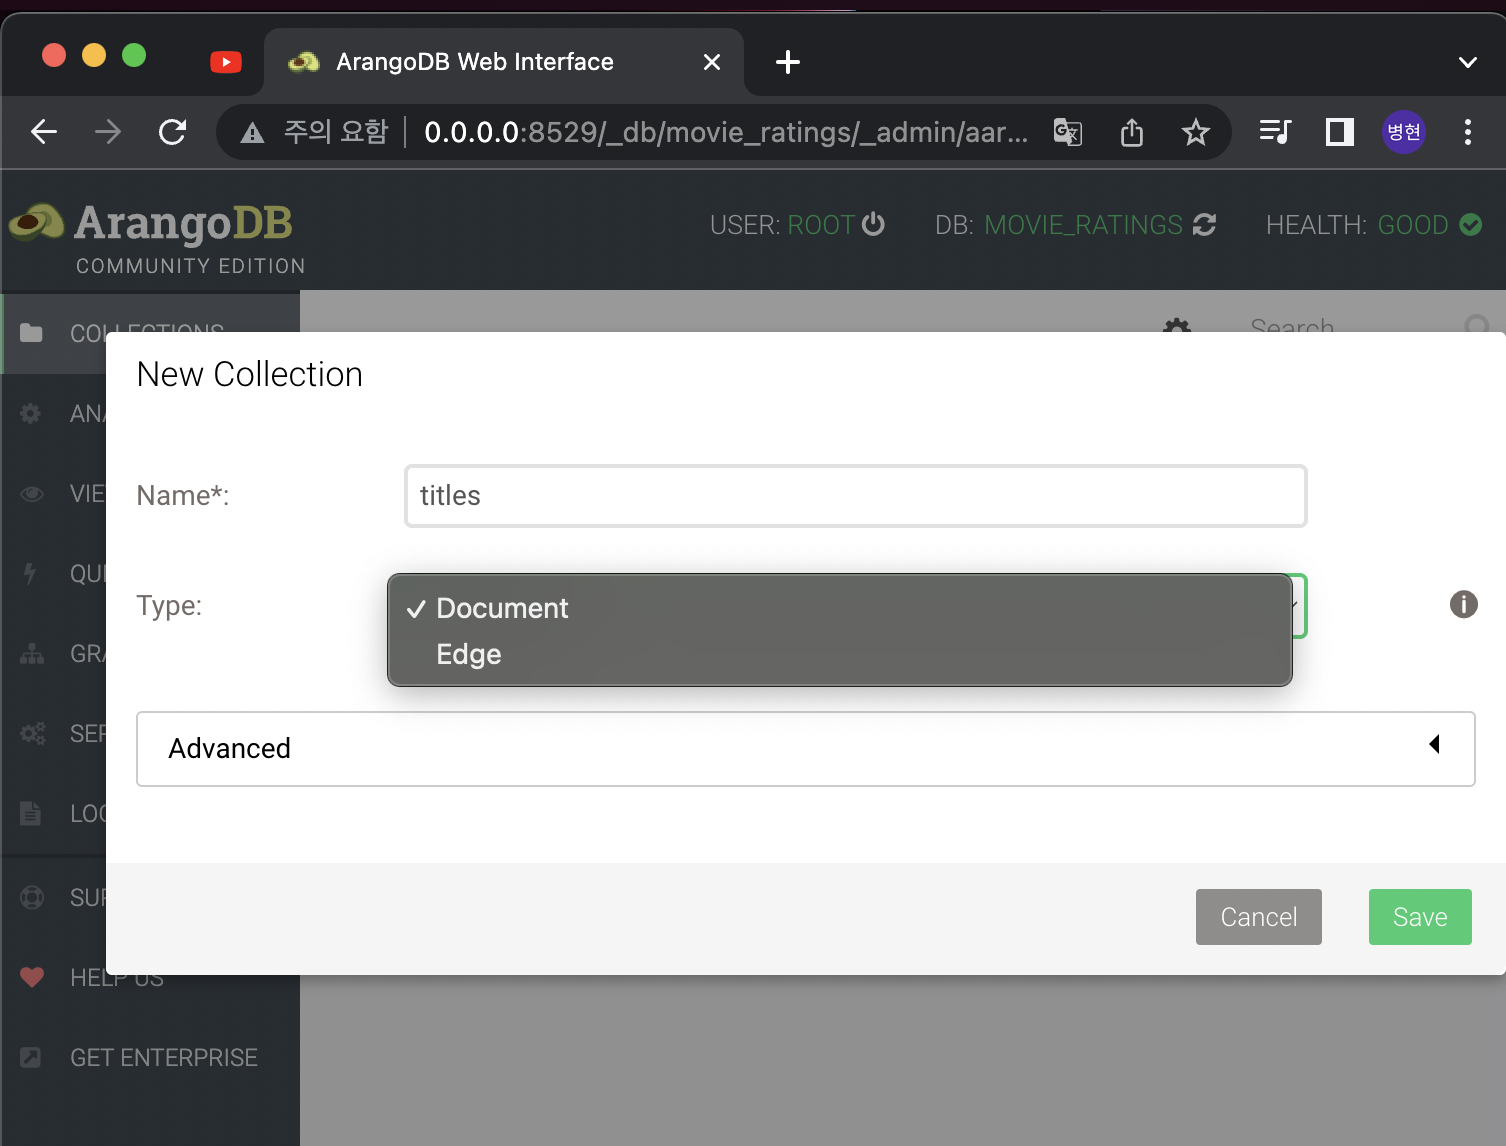

In [11]:
movielens_collection = database_obj.createCollection(name="titles")
movielens_collection

ArangoDB collection name: titles, id: 202, type: document, status: loaded

> title이라는 Collections가 생성됐나 Web-UI를 통해 확인요망

### 3. 생성한 영화 Collections 생성

##### 3.1. Collection에 넣을 영화데이터 Load및 전처리

In [18]:
import pandas as pd

movies = pd.read_csv('https://raw.githubusercontent.com/ud803/ud803.github.io/main/public/movie_titles.csv', encoding='ISO-8859-1', header=None, names=['id', 'year', 'name'], error_bad_lines=False)
ratings = pd.read_csv('https://raw.githubusercontent.com/ud803/ud803.github.io/main/public/netflix.csv', encoding='ISO-8859-1', header=None, names=['user', 'movie', 'rating', 'date'])

# dropNA
movies = movies.dropna()
# 제작 연도를 float=> 정수형으로 바꿔준다
movies = movies.astype({'year' : 'int32'})

print(movies.shape, ratings.shape)

(17427, 3) (84942, 4)


##### 3.2. 아랑고DB에 넣을 영화 데이터 설계하기

```
영화 추천 시스템이니까 당연히 영화(M)라는 버텍스가 있어야 하고, 사람(U)을 나타내는 버텍스가 또 있어야 한다. 또한, 출시연도도 활용할것

그리고 사람(U)이 영화(M)를 평가(R)하는 엣지가 중간에 존재해야 한다.

아래의 같은 5개의 컬렉션들이 생성되어야 한다.

* `Vertex Collection` : 영화(Movie), 사람(User), 출시연도(Year)
* `Edge Collection` : (사람)-[rated]->(영화), (영화)-[created_at]->(출시연도)
```

|Collection Name|Collection type|비고|from-to|
|--|--|--|--|
|Movie|vertex|unique_vertex|-|
|Year|vertex|unique_vertex|-|
|User|vertex|unique_vertex|-|
|rated|edge|unique_edge_on_event|User - rated -> Movie|
|created_at|edge|unique_edge_btw_vertices|Movie - created_at -> Year|

##### 3.3. 아랑고DB에 데이터 맵핑하기 - (스키마 설계하기)

In [35]:
#!pip install python-arango-mapper

In [46]:
schemas = {
# Type 1
    'Movie': {
        'type': ('vertex', 'unique_vertex'),
        'collection': 'Movie',
        'unique_key': ('id',),
        'fields': {
            'name': 'name',
            'year': 'year'
        },
        'index': [
            {'field' : ('name',), 'unique' : False, 'ttl' : False}
        ]
    },
    # Type 1
    'Year': {
        'type': ('vertex', 'unique_vertex'),
        'collection': 'Year',
        'unique_key': ('year',),
        'fields': {
            'year': 'year'
        },
        'index': [
            {'field' : ('year',), 'unique' : True, 'ttl' : False}
        ]
    },
    # Type 1
    'User': {
        'type': ('vertex', 'unique_vertex'),
        'collection': 'User',
        'unique_key': ('user',),
        'fields': {
            'user': 'user'
        },
        'index': [
            {'field' : ('user',), 'unique' : True, 'ttl' : False}
        ]
    },


    # User - rated -> Movie
    # Type 3
    'rated': {
        'type': ('edge', 'unique_edge_on_event'),
        'collection': 'rated',
        'unique_key': ('date',),
        '_from_collection': 'User',
        '_from': ('user',),
        '_to_collection': 'Movie',
        '_to': ('movie',),
        'fields': {
            'rating': 'rating',
            'date': 'date'
        },
        'index': []
    },

    # Movie - created_at -> Year
    # Type 2
    'created_at': {
        'type': ('edge', 'unique_edge_btw_vertices'),
        'collection': 'created_at',
        '_from_collection': 'Movie',
        '_from': ('id',),
        '_to_collection': 'Year',
        '_to': ('year',),
        'fields': {
        },
        'index': []
    }
}


##### 3.4. 본격적으로 Collection에 스키마에 맞게 데이터 Input

In [24]:
from pam import client, database, converter

#3.4.1. ArangoDB에 # ArangoDB에 연결
arango_conn = client.get_arango_conn(hosts="http://localhost:8529")
database_obj = database.create_and_get_database(arango_conn, 'movie_ratings', 'root', 'password')

In [25]:
#3.4.2. 데이터프레임을 딕셔너리의 리스트 형태로 바꿔준다
data_1 = movies.to_dict('records')

In [40]:
#3.4.3. 전체 스키마를 사용하는 것이 아니기 때문에 사용할 리스트를 지정해준다
data_1_map = ['Movie', 'created_at', 'Year']
converter.arango_converter(data_1, database_obj, schemas, data_1_map)

In [48]:
#3.4.4. Data 2 Upload
data_2 = ratings.to_dict('records')
data_2_map = ['User', 'rated']
converter.arango_converter(data_2, database_obj, schemas, data_2_map)

> 데이터 잘 들어가졌는지는 WEB-UI를 통해 확인할 것